In [119]:
!pip install xgboost

#  Required Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
train_df = pd.read_csv(r"C:\Users\Administrator\Algorithms Practice\Titanic Survival Kaggle Project\train.csv")

#  EDA

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
corr_matrix = train_df.corr(numeric_only=True)
corr_matrix['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

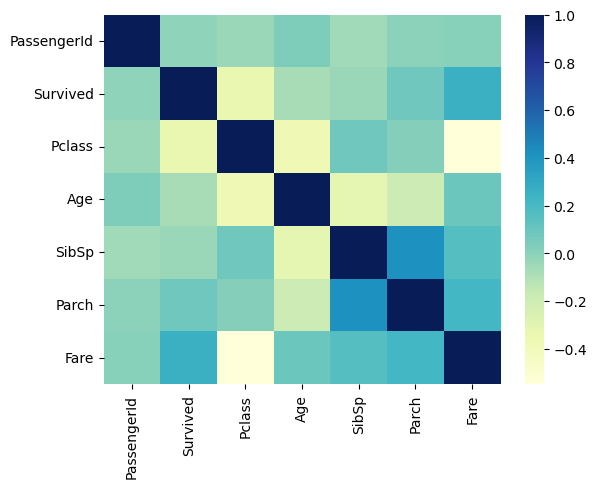

In [5]:
sns.heatmap(corr_matrix, cmap='YlGnBu')
plt.show()

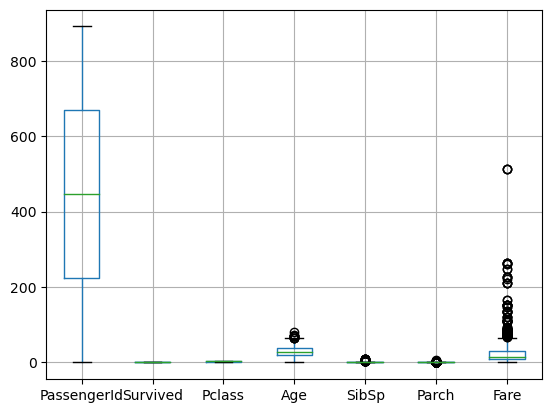

In [6]:
train_df.boxplot()
plt.show()

<Axes: xlabel='Sex', ylabel='count'>

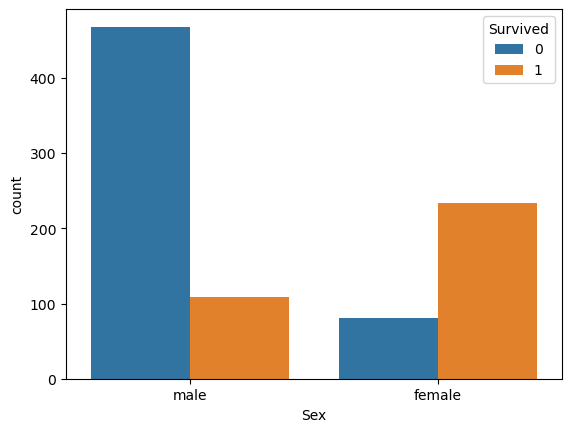

In [7]:
sns.countplot(x='Sex',  hue='Survived', data=train_df)

In [8]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

<Axes: xlabel='Pclass', ylabel='count'>

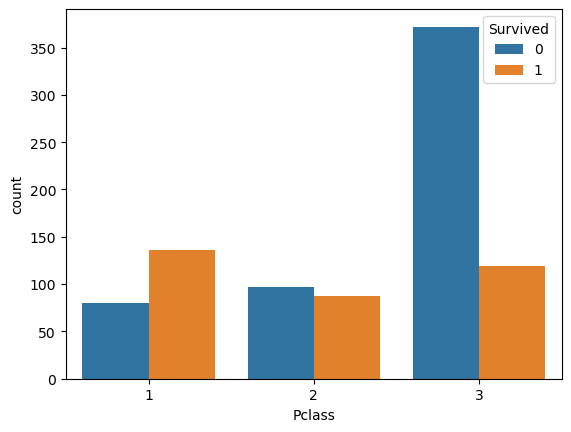

In [9]:
sns.countplot(x='Pclass', hue='Survived', data=train_df)

<Axes: xlabel='Embarked', ylabel='count'>

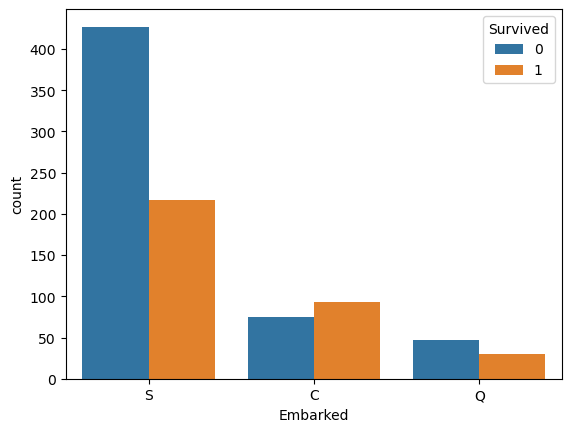

In [10]:
sns.countplot(x='Embarked', hue='Survived', data=train_df)

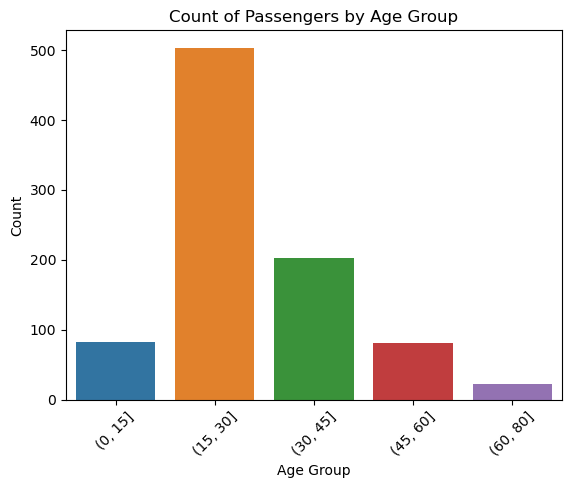

In [11]:
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)

train_df['Age_Group'] = pd.cut(train_df['Age'], bins = [0,15,30,45,60,80])

sns.countplot(x='Age_Group', data=train_df)
plt.title('Count of Passengers by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)  
plt.show()


<Axes: >

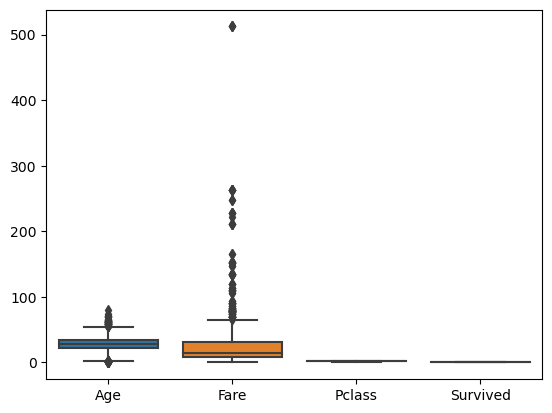

In [12]:
sns.boxplot(data=train_df[['Age', 'Fare', 'Pclass', 'Survived']])

In [13]:
train_df.corr(numeric_only=True)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.034212,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.064910,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.339898,0.083081,0.018443,-0.549500
Age,0.034212,-0.064910,-0.339898,1.000000,-0.233296,-0.172482,0.096688
SibSp,-0.057527,-0.035322,0.083081,-0.233296,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.172482,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096688,0.159651,0.216225,1.000000


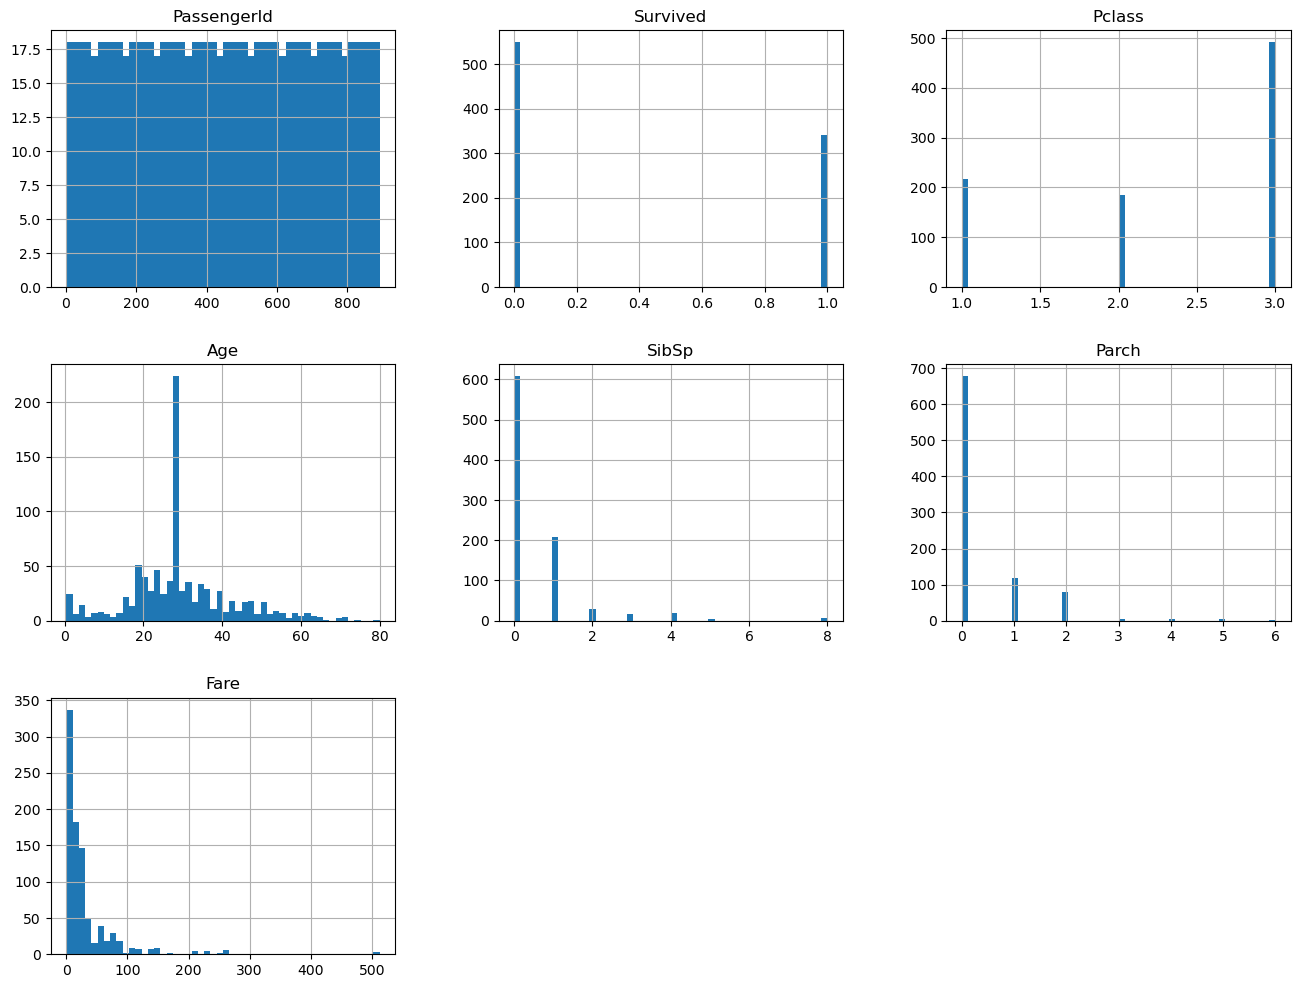

In [14]:
train_df.hist(bins=50, figsize=(16,12))
plt.show()

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

# Custom class 

In [16]:
class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        '''Add new features'''
        X = X.copy()
        X['Family_size'] = X['SibSp'] + X['Parch'] + 1
        X['isAlone'] = (X['Family_size'] == 1).astype('int') 
        
        # Fill missing 'Embarked' with the most common value
        X['Embarked'].fillna(X['Embarked'].mode()[0], inplace=True)
        
        # Fill missing 'Age' with median based on 'Pclass' and 'Sex' groupings
        X['Age'] = X.groupby(['Pclass', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
        
        # Drop unnecessary columns
        X = X.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
        
        return X

# Pipeline

In [17]:
# Define pipelines for numerical and categorical processing
num_features = ['Age', 'Family_size']
cat_features = ['Sex', 'Embarked', 'Pclass', 'isAlone']

# Log transformation pipeline (only for 'Fare')
log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log1p, feature_names_out='one-to-one'),
    StandardScaler()
)

# Standard processing for other numeric features
num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

# Categorical pipeline
cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')   
)

# Define preprocessing step using ColumnTransformer
preprocessing = ColumnTransformer(
    transformers=[
        ('log', log_pipeline, ['Fare']),  # Only apply log transformation to 'Fare'
        ('num', num_pipeline, num_features),  # Standard numerical processing
        ('cat', cat_pipeline, cat_features)  # Process categorical features
    ]
)

# Full Pipeline to include Feature Engineering first
full_pipeline = Pipeline(steps=[
    ('feature_engineering', FeatureEngineering()),  # Apply custom feature engineering
    ('preprocessing', preprocessing)  # Apply preprocessing after new features are created
])



# Apply the pipeline
transformed_data = full_pipeline.fit_transform(train_df)

# Output the shape and a sample of the transformed data
print("Transformed data shape:", transformed_data.shape)
print("Sample of transformed data:")
print(transformed_data[:5])
preprocessing.get_feature_names_out()

Transformed data shape: (891, 13)
Sample of transformed data:
[[-0.87974057 -0.56573646  0.05915988  0.          1.          0.
   0.          1.          0.          0.          1.          1.
   0.        ]
 [ 1.36121993  0.66386103  0.05915988  1.          0.          1.
   0.          0.          1.          0.          0.          1.
   0.        ]
 [-0.79853997 -0.25833709 -0.56097483  1.          0.          0.
   0.          1.          0.          0.          1.          0.
   1.        ]
 [ 1.06203806  0.4333115   0.05915988  1.          0.          0.
   0.          1.          1.          0.          0.          1.
   0.        ]
 [-0.78417924  0.4333115  -0.56097483  0.          1.          0.
   0.          1.          0.          0.          1.          0.
   1.        ]]


array(['log__Fare', 'num__Age', 'num__Family_size', 'cat__Sex_female',
       'cat__Sex_male', 'cat__Embarked_C', 'cat__Embarked_Q',
       'cat__Embarked_S', 'cat__Pclass_1', 'cat__Pclass_2',
       'cat__Pclass_3', 'cat__isAlone_0', 'cat__isAlone_1'], dtype=object)

In [18]:
X = pd.DataFrame(transformed_data, columns=preprocessing.get_feature_names_out())
y = train_df['Survived']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   log__Fare         891 non-null    float64
 1   num__Age          891 non-null    float64
 2   num__Family_size  891 non-null    float64
 3   cat__Sex_female   891 non-null    float64
 4   cat__Sex_male     891 non-null    float64
 5   cat__Embarked_C   891 non-null    float64
 6   cat__Embarked_Q   891 non-null    float64
 7   cat__Embarked_S   891 non-null    float64
 8   cat__Pclass_1     891 non-null    float64
 9   cat__Pclass_2     891 non-null    float64
 10  cat__Pclass_3     891 non-null    float64
 11  cat__isAlone_0    891 non-null    float64
 12  cat__isAlone_1    891 non-null    float64
dtypes: float64(13)
memory usage: 90.6 KB


# XGBClassifier Model Pipeline 

In [19]:
xgb_pipeline = Pipeline([
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, enable_categorical=True))
])
xgb_pipeline.fit(X,y)

C:\Users\Administrator\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:56:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=True, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [20]:
# Make predictions on the training data
train_predictions = xgb_pipeline.predict(X)

# Display the predictions
print("Predictions on training data:", train_predictions[:10])
print('y:', y[:10])


Predictions on training data: [0 1 1 1 0 0 0 0 1 1]
y: 0    0
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    1
9    1
Name: Survived, dtype: int64


In [21]:
from sklearn.metrics import accuracy_score

# Calculate and display the accuracy on the training data
train_accuracy = accuracy_score(y, train_predictions)
print("Training set accuracy:", train_accuracy)

Training set accuracy: 0.9652076318742986


In [22]:
test_df = pd.read_csv(r"C:\Users\Administrator\Algorithms Practice\Titanic Survival Kaggle Project\test.csv")
X_test = full_pipeline.fit_transform(test_df)

In [23]:
# Assuming X_test is the test data
test_predictions = xgb_pipeline.predict(X_test)

# Display the predictions
print("Predictions on test data:", test_predictions[0:10])

Predictions on test data: [0 0 0 1 1 0 0 0 1 0]


# Accuracy meaures

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline on the training data
xgb_pipeline.fit(X_train, y_train)

# Make predictions on the test data
test_predictions = xgb_pipeline.predict(X_test)

# Calculate and display the accuracy on the test data
test_accuracy = accuracy_score(y_test, test_predictions)
print("Test set accuracy:", test_accuracy)

Test set accuracy: 0.7988826815642458


C:\Users\Administrator\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:06:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [31]:

# Define hyperparameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

# Use GridSearchCV to optimize hyperparameters
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on the test set
test_score = grid_search.score(X_test, y_test)
print("Test set score:", test_score)

Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Best cross-validation score: 0.8398798384713878
Test set score: 0.8268156424581006


C:\Users\Administrator\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:12:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [32]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions on the test set
test_predictions = grid_search.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, test_predictions))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       105
           1       0.82      0.74      0.78        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179

Confusion Matrix:
[[93 12]
 [19 55]]


# Extract Best Model(using GridSearchCV) & Find important features 

In [35]:
# Extract the best estimator from GridSearchCV
best_model = grid_search.best_estimator_.named_steps['classifier']

# Get feature importances from the XGBoost model
importances = best_model.feature_importances_


# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({
    'Feature': preprocessing.get_feature_names_out(),
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display feature importance
print("Feature Importances:")
feature_importance_df.sort_values(by='Importance', ascending=False)


Feature Importances:


,Feature,Importance
3,cat__Sex_female,0.319881
4,cat__Sex_male,0.215543
10,cat__Pclass_3,0.139057
8,cat__Pclass_1,0.076203
2,num__Family_size,0.046703
0,log__Fare,0.037486
7,cat__Embarked_S,0.037078
1,num__Age,0.032962
11,cat__isAlone_0,0.030560
5,cat__Embarked_C,0.025924


# Making New Predition

In [38]:
# Example new data (must match the format of training features)
new_data = pd.DataFrame({
    "PassengerId": [101],
    "Pclass": [2],
    "Name": ["New, Mr. Test Person"],
    "Sex": ["male"],
    "Age": [30],
    "SibSp": [0],
    "Parch": [0],
    "Ticket": ["12345"],
    "Fare": [12.5],
    "Cabin": [None],
    "Embarked": ["S"]
})

# Convert object columns to category (optional but helps if you need to work with categorical types)
new_data['Name'] = new_data['Name'].astype('category')
new_data['Sex'] = new_data['Sex'].astype('category')
new_data['Ticket'] = new_data['Ticket'].astype('category')
new_data['Cabin'] = new_data['Cabin'].astype('category')
new_data['Embarked'] = new_data['Embarked'].astype('category')

# Step 1: Manually Create Missing Features
# Assuming that `Family_size` is calculated as `SibSp + Parch + 1`
new_data['Family_size'] = new_data['SibSp'] + new_data['Parch'] + 1

# Assuming that `isAlone` is 1 if `Family_size` is 1, otherwise 0
new_data['isAlone'] = (new_data['Family_size'] == 1).astype(int)

# Step 2: Preprocess the new_data using the preprocessing pipeline
try:
    new_data_processed = preprocessing.transform(new_data)

    # Step 3: Make predictions using the trained model
    new_predictions = grid_search.predict(new_data_processed)
    print("Prediction for new passenger:", new_predictions)

except ValueError as e:
    print("Error during prediction:", e)


Prediction for new passenger: [0]


# Save the Model

In [41]:
import joblib

# Save the best model from GridSearchCV
joblib.dump(grid_search.best_estimator_, 'best_xgboost_model.pkl')

# To load the model later
loaded_model = joblib.load('best_xgboost_model.pkl')

['best_xgboost_model.pkl']